# Named Entity Recognition and Classification

Named Entity Recognition is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories. The projects aims to classify the text in the articles in the Location, Person and Organization category

### Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords

# Machine learning
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Deep learning
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import text_to_word_sequence

# Visualization
import pyLDAvis
import pyLDAvis.gensim
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Data Analysis
import pandas as pd
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import scipy.stats
import eli5
import string
from IPython.display import Image
from collections import Counter
from pattern.de import parse, split

### Load Train and Test Dataset

In [5]:
df_nlp1 = pd.read_csv("NLP-1_12-17-2019.bio", sep=" ", names = ['Word','Tag'], encoding='utf-8')
df_nlp2 = pd.read_csv("NLP-2_12-17-2019.bio", sep=" ", names = ['Word','Tag'], encoding='utf-8')

#### Combined the two datasets and then splitted them later into train, test and validation

In [6]:
df_add = df_nlp1.append(df_nlp2)

In [7]:
df_add = df_add.reset_index(drop=True)

### Include sentence number

In [9]:
# Included sentence number by taking a simple assumption that sentences end with full stop.

count = 1
for index, row in df_add.iterrows():
    df_add.loc[index,'Sentence #'] = count
    if row['Word'] == '.':
        count += 1

### Include POS tagging

In [11]:
# Used pattern.de named part-of-speech tagger for European languages especially German

def pos(sent):
    token = parse(sent)
    pos = token.split('/')
    return pos[1]

In [15]:
df_add['POS'] = df_add['Word'].apply(lambda x: pos(x))

In [ ]:
df_add[:5]

### Frequency for each tag in train and test

In [19]:
df_add.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-LOC,4203
1,B-ORG,1062
2,B-PER,3698
3,I-LOC,954
4,I-MISC,3
5,I-ORG,1372
6,I-PER,2912
7,O,69384


In [33]:
y = df_add.Tag.values

In [34]:
classes = np.unique(y)
classes = classes.tolist()
classes

['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [35]:
# Training using all the classes but classification only for PER, ORG and LOC

new_classes = classes.copy()
new_classes.remove('I-MISC')
new_classes.remove('O')

In [36]:
new_classes

['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER']

### Extract out sentences with POS and Tags for corresponding tokens

In [32]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s 
        except:
            return None

In [33]:
getter = SentenceGetter(df_add)

In [34]:
sent = getter.get_next()

In [35]:
sentences = getter.sentences

In [36]:
sentences[0]

[('Eintracht', 'NN', 'O'),
 (',', ',', 'O'),
 ('die', 'DT', 'O'),
 ('nicht', 'RB', 'O'),
 ('nur', 'RB', 'O'),
 ('ideal', 'JJ', 'O'),
 ('eine', 'DT', 'O'),
 ('Quelle', 'NN', 'O'),
 ('des', 'DT', 'O'),
 ('Wohlergehens', 'NN', 'O'),
 ('dies', 'DT', 'O'),
 ('-', '-', 'O'),
 ('und', 'CC', 'O'),
 ('jenseits', 'RB', 'O'),
 ('des', 'DT', 'O'),
 ('Brenners', 'NN', 'B-LOC'),
 ('sein', 'VB', 'O'),
 ('kann', 'VB', 'O'),
 (',', ',', 'O'),
 ('nicht', 'RB', 'O'),
 ('eine', 'DT', 'O'),
 ('Angriffs', 'NN', 'O'),
 ('-', '-', 'O'),
 ('oder', 'CC', 'O'),
 ('Verteidigungsgrenze', 'NN', 'O'),
 (',', ',', 'O'),
 ('sondern', 'CC', 'O'),
 ('eine', 'DT', 'O'),
 ('Linie', 'NN', 'O'),
 ('der', 'DT', 'O'),
 ('Verbindung', 'NN', 'O'),
 ('und', 'CC', 'O'),
 ('der', 'DT', 'O'),
 ('Anpassung', 'NN', 'O'),
 ('zwischen', 'IN', 'O'),
 ('zwei', 'CD', 'O'),
 ('Völkern', 'NN', 'O'),
 ('soll', 'MD', 'O'),
 ('es', 'PRP', 'O'),
 ('sein', 'VB', 'O'),
 (',', ',', 'O'),
 ('für', 'IN', 'O'),
 ('die', 'DT', 'O'),
 ('zwei', 'CD', 'O

### Data Pre-processing for EDA

In [39]:
stopwords = set(stopwords.words())

In [40]:
def clean(text):
    text = word_tokenize(text)
    text = [word.lower() for word in text if word.isalpha()]
    punct = str.maketrans('', '', string.punctuation)
    text = [word.translate(punct) for word in text]
    text = [word for word in text if not word in stopwords]
    return text

In [42]:
df_clean = df_add.copy()
df_clean['Word'] = df_clean['Word'].apply(clean)

### Text Corpus and Highest Frequency Words after pre-processing

In [44]:
text_corpus = ''
def counter(text):
    global text_corpus
    cnt = Counter()
    for msgs in text:
        for msg in msgs:
            text_corpus += msg + ' '
            cnt[msg] += 1
    return cnt

text_cnt = counter(df_clean['Word'])

In [46]:
text_cnt.most_common(10)

[('wurde', 226),
 ('herr', 167),
 ('bolzano', 164),
 ('merano', 149),
 ('italien', 147),
 ('deutschland', 134),
 ('wien', 126),
 ('nr', 126),
 ('johann', 121),
 ('herrn', 118)]

## Exploratory Data Analysis

### Wordcloud

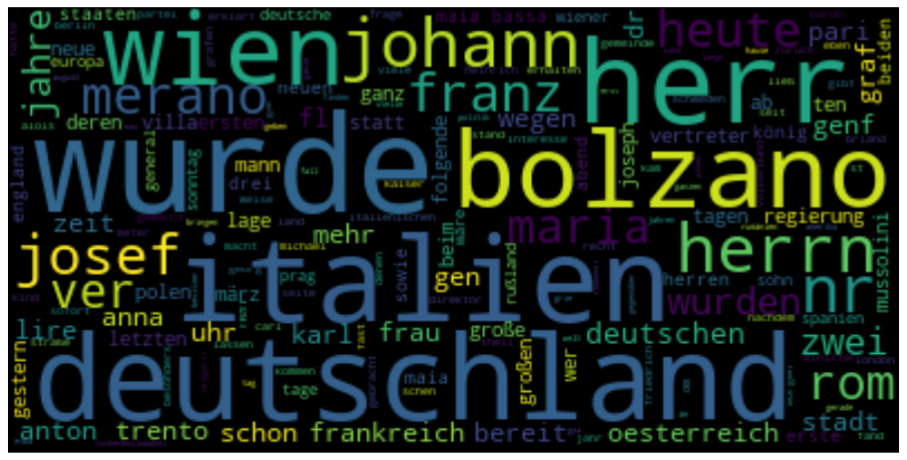

In [47]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60).generate(text_corpus)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The size of the word in the Wordcloud is bigger for more frequent word and smaller for less frequent word.
After we have processed the text and obtained a clean corpus, we can infer from the Wordcloud that the article mostly
talks about historical Italian cities like Bolzano, Merano, Trento, Rom and Italian currency Lira. Texts are written in European languages mostly in German.

### Topic Modelling using LDA

In [48]:
dictionary = gensim.corpora.Dictionary(df_clean['Word'])

In [49]:
# Filter out tokens that appear in less than no_below documents (absolute number) or more than no_above documents (fraction of total corpus size, not absolute number). after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).
dictionary.filter_extremes(no_below=25, 
                           no_above=0.5, 
                           keep_n=100000)

In [50]:
#Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.
bow2doc_corpus = [dictionary.doc2bow(text) for text in df_clean['Word']]

In [51]:
lda_model = gensim.models.LdaMulticore(bow2doc_corpus, 
                                       num_topics=5, 
                                       id2word=dictionary, 
                                       passes=50, 
                                       workers=4,
                                      chunksize=500)

In [72]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.134*"nr" + 0.132*"herr" + 0.112*"johann" + 0.058*"deutschland" + 0.057*"ver" + 0.046*"beim" + 0.043*"mann" + 0.031*"dr" + 0.030*"gen" + 0.029*"maia"
Topic: 1 
Words: 0.104*"wurde" + 0.081*"herrn" + 0.056*"stadt" + 0.053*"schon" + 0.049*"karl" + 0.045*"prag" + 0.033*"ganz" + 0.032*"rom" + 0.032*"b" + 0.031*"deren"
Topic: 2 
Words: 0.120*"wien" + 0.098*"franz" + 0.073*"r" + 0.060*"paris" + 0.053*"wurden" + 0.050*"zwei" + 0.049*"anna" + 0.047*"heute" + 0.039*"mehr" + 0.035*"zeit"
Topic: 3 
Words: 0.168*"fl" + 0.103*"josef" + 0.081*"bolzano" + 0.077*"graf" + 0.074*"merano" + 0.054*"wegen" + 0.048*"frankreich" + 0.044*"g" + 0.043*"sohn" + 0.038*"w"
Topic: 4 
Words: 0.082*"maria" + 0.078*"uhr" + 0.073*"italien" + 0.057*"joseph" + 0.057*"anton" + 0.050*"frau" + 0.043*"deutschen" + 0.042*"oesterreich" + 0.039*"kind" + 0.038*"general"


In [ ]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, 
                              corpus=bow2doc_corpus, 
                              dictionary=dictionary)

# Use below command to see interactive LDA visualization using a server and it will redirect to 127.0.0.1:8000
# pyLDAvis.show(vis)

# Use below command to see visualization in Jupyter Notebook
# CAREFUL with below command as it has a bug that causes JUPYTER UI to break, reported bug to the repo owner
# pyLDAvis.show()

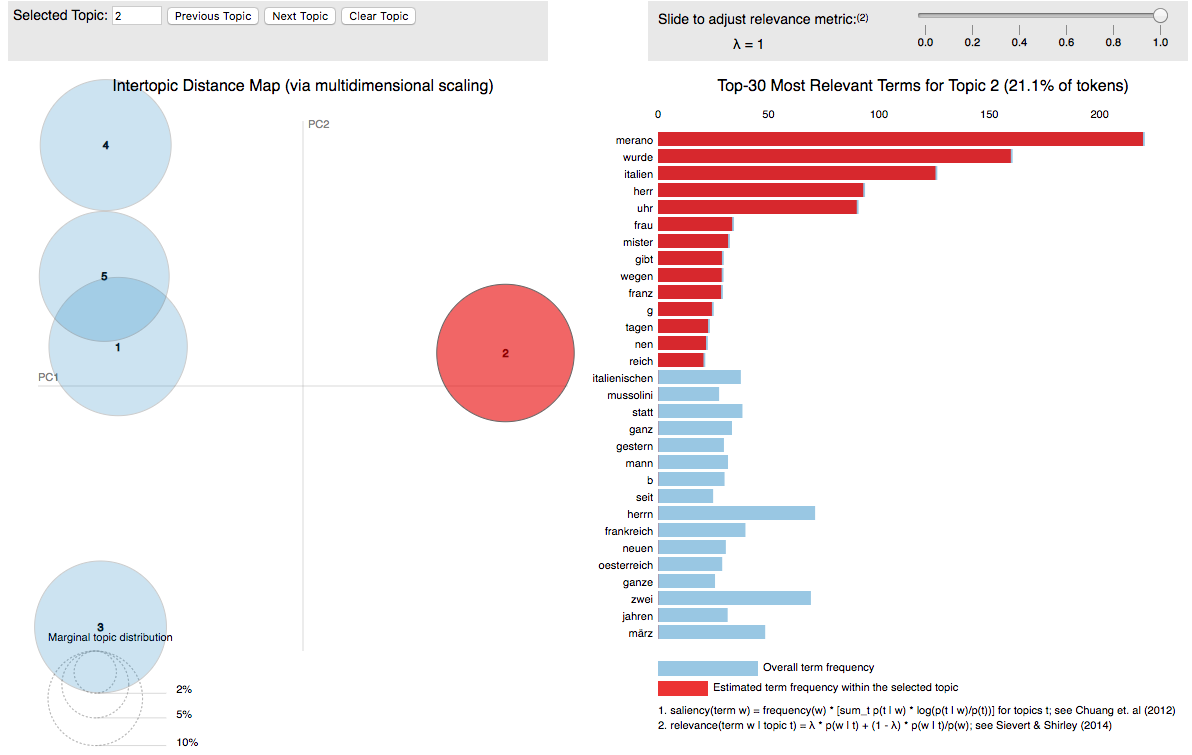

In [73]:
# I have included a snapshot of the LDA visualization because the above command from pyLDAvis framework results in aberrant behavior
Image(filename='LDA.png')

Top topics were retrieved from the results after performing LDA on text corpus.

We can see that topic 3 corresponds to Italy, topic 1 & 2 about European places and topic 0 mostly about history.
The visualization gives us meaningful important information related to various topics present in the articles.

### Lexical Dispersion

In [74]:
tokens_disperse = nltk.word_tokenize(text_corpus)
text_disperse = nltk.Text(tokens_disperse)

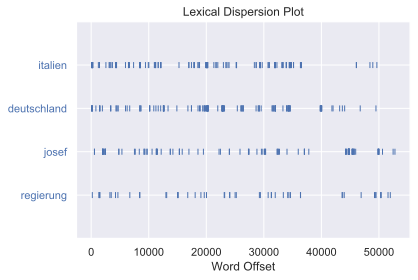

In [76]:
text_disperse.dispersion_plot(["italien","deutschland","josef","regierung"])

Lexical dispersion is a measure of a word’s homogeneity across the parts of a corpus. This plot notes the occurrences of a word and how many words from the beginning of the corpus it appears.
So we can observe that in the beginning, the article talks more about countries Italien (Italy) and deutschland (Germany) and they occur more frequently but towardds the end the article talks more about person Josef and regierung (government organization) so we can see a slight change in the context as we read the article.

### High Frequency Words Bar Plot 

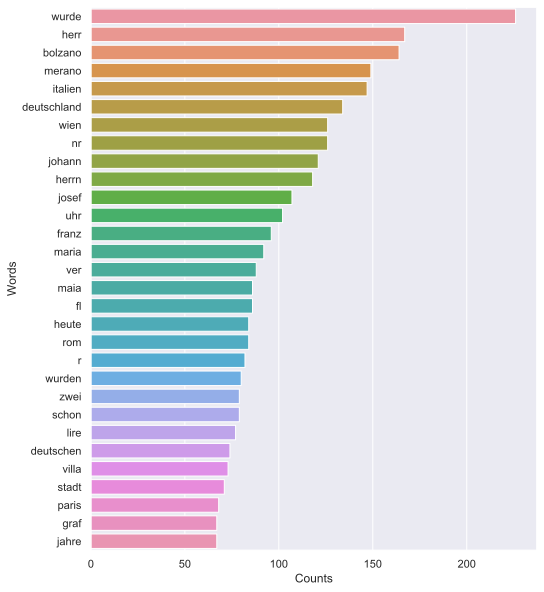

In [77]:
common_words = text_cnt.most_common(30)
common_words = pd.DataFrame(common_words, columns = ['Words', 'Counts'])
plt.figure(figsize=(8,10))
sns.barplot(y="Words", x="Counts", data=common_words)

From the above frequency graph, we can see that high frequency words are dominated by locations like Italian cities
followed by person such as Josef and Maria and then by organization such as regierung.

### Sentence Length Distribution

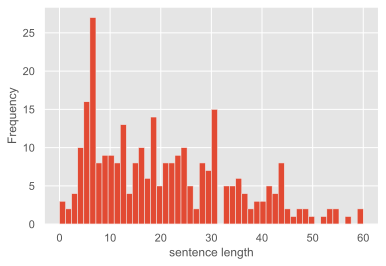

In [78]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50, range=[0,60])
plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.show()

We can observe that that most of the sentences are in the range of 5-20 and the distribution is close to normal

### Words distribution across Tag

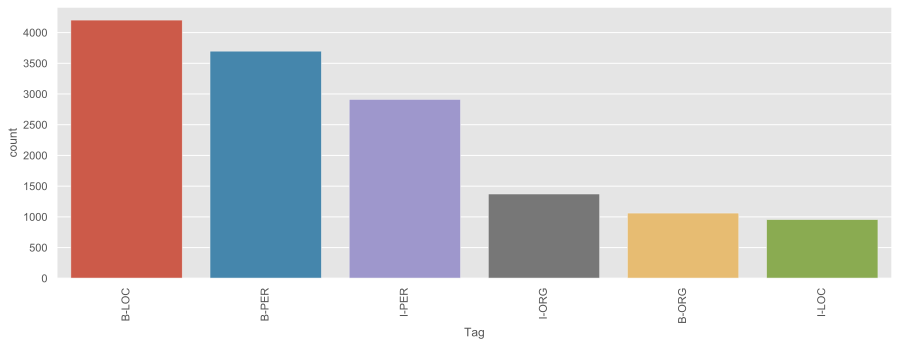

In [79]:
plt.figure(figsize=(15, 5))
plot_data = df_add.loc[(df_add['Tag'] != 'O') & (df_add['Tag'] != 'I-MISC')]
ax = sns.countplot('Tag', data=plot_data,order = plot_data['Tag'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.show()

Words distribution across Tags after removing the unnecessary tags 'I-MISC' and 'O'.
Distribution dominated mostly by LOC, then PER and finally ORG

### Words distribution across POS

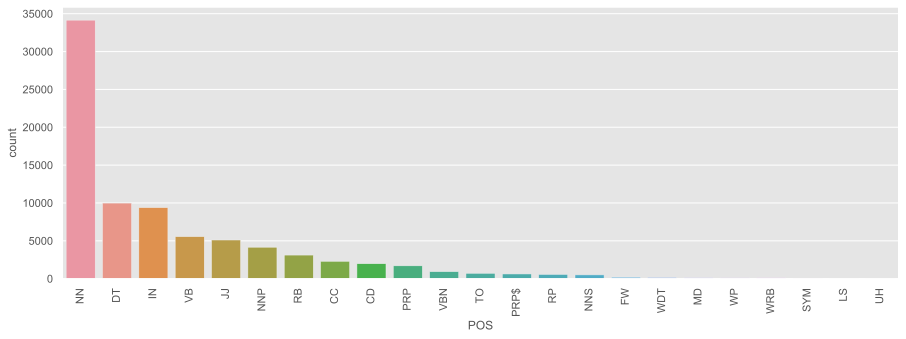

In [80]:
plt.figure(figsize=(15, 5))
filter_data = df_add.loc[(df_add['POS'] != '.') & (df_add['POS'] != ',') & (df_add['POS'] != '(') & (df_add['POS'] != ')') & (df_add['POS'] != ':') & (df_add['POS'] != '-')]
ax = sns.countplot('POS', data=df_add, orient='h', order=filter_data['POS'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.show()

Most of the words in the text corpus are Noun, Determiner, Verb, adjective and preposition

### Seperate feature columns and decision label

In [52]:
X = df_add.drop('Tag', axis=1)

In [53]:
# Transform text data to vector using DictVectorizer

v = DictVectorizer(sparse=False)
X = v.fit_transform(X.to_dict('records'))

In [54]:
y = df_add.Tag.values

In [55]:
classes = np.unique(y)
classes = classes.tolist()
classes

['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [56]:
# Training using all the classes but classification only for PER, ORG and LOC

new_classes = classes.copy()
new_classes.remove('I-MISC')
new_classes.remove('O')

In [57]:
new_classes

['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER']

### Baseline Decision Tree model

In [116]:
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])

In [117]:
words = [feature_map(w) for w in df_add["Word"].values.tolist()]
tags = df_add["Tag"].values.tolist()

In [118]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(words, tags, test_size = 0.33, random_state=0)

In [119]:
clf = DecisionTreeClassifier()

In [120]:
clf = clf.fit(X_train_dt,y_train_dt)

In [121]:
y_pred=clf.predict(X_test_dt)

In [134]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=y_pred, y_true=y_test_dt, labels = new_classes)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00      1385
       B-ORG       0.33      0.01      0.01       380
       B-PER       0.00      0.00      0.00      1180
       I-LOC       0.00      0.00      0.00       306
       I-ORG       0.17      0.00      0.00       438
       I-PER       0.00      0.00      0.00       938

   micro avg       0.16      0.00      0.00      4627
   macro avg       0.08      0.00      0.00      4627
weighted avg       0.04      0.00      0.00      4627



I have taken precision, recall and F1 score as the evaluation metric because the data is really skewed because most of the tags lie in 'O' category, that's why taking accuracy would not be correct. So it is an imbalanced classification problem. Precision, recall and F1 score are sensitive to imbalanced data, therefore perfect for such kind of problem.

The baseline model performed badly. The precision and recall values of most of the classes were 0. Surprisingly ORG is performing better despite having less data for training.
It seems the features which require the model to take proper decisions are missing. The model is basically memorizing words and tags which is not satisfying our requirement.
Next step is to move to a complex model that have far more contextual features for classification 

## Conditional Random Field

A Conditional Random Field (CRF) is a standard model for predicting the most likely sequence of labels that correspond to a sequence of inputs. It is a supervised learning method which has been proven to be better than the tree based models when it comes to NER. Whereas a discrete classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account; e.g., the linear chain CRF (which is popular in natural language processing) predicts sequences of labels for sequences of input samples.

### Feature Extraction

Since we need to take into account the context as well, we create features which will provide consecutive POS tags for each word. Also, we add new features such as upper, lower, digit, title etc. for each word and also consider the consecutive words in the list. In short, we try to provide a sequence of features to the model for each word - the sequence containing POS tags, capitalisations, type of word(title) etc.

In [83]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]


In [139]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [141]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=20,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [142]:
y_pred = crf.predict(X_test)

In [143]:
print(metrics.flat_classification_report(y_test, y_pred, labels = new_classes))


              precision    recall  f1-score   support

       B-LOC       0.75      0.37      0.49      1568
       B-ORG       0.27      0.17      0.21       299
       B-PER       0.63      0.32      0.43      1536
       I-LOC       0.52      0.11      0.18       330
       I-ORG       0.21      0.32      0.26       371
       I-PER       0.55      0.39      0.46      1377

   micro avg       0.54      0.33      0.41      5481
   macro avg       0.49      0.28      0.34      5481
weighted avg       0.59      0.33      0.42      5481



Compared to the Random Forest classifier, the CRF classifier did better as the scores have improved. However, the precision and recall metrics of the classes individually have not improved. Maybe the model is again remembering words and not taking into the context information completely. We will try tuning the model to see if we can improve it.

## CRF with Hyperparameter Tuning

Best hyperparameters obtained by performing hypertuning with RandomizedSearchCV and doing 3 fold cross validation using the training data.

Hypertuning can be done on a wide search space which is resource and computationally intensive and can be done on powerful cloud servers and using GPU.

In [ ]:
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=new_classes)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

rs.fit(X_train, y_train)

In [132]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=new_classes))

              precision    recall  f1-score   support

       B-LOC       0.79      0.54      0.64      1568
       B-ORG       0.59      0.34      0.43       299
       B-PER       0.76      0.48      0.59      1536
       I-LOC       0.66      0.36      0.47       330
       I-ORG       0.49      0.39      0.43       371
       I-PER       0.70      0.50      0.58      1377

   micro avg       0.72      0.48      0.58      5481
   macro avg       0.66      0.44      0.52      5481
weighted avg       0.72      0.48      0.58      5481



The average score has increased and the individual precision and recall scores have improved. The model is trying to understand the context as well and not just remember words.

We can observe that precision scores for all the classes have significantly improved with LOC and PER performing the best. Recall scores have improved certainly after training but not as much as the precision scores. However, F1 score has a respectable score now for such a noisy dataset.

## Bidirectional LSTM Approach

Bidirectional LSTM  can provide additional context to the network and result in faster and even fuller learning on the problem.
It has two networks, one access information in forward direction and another access in the reverse direction . These networks have access to the past as well as the future information and hence the output is generated from both the past and future context. 

In [148]:
# Configurable parameters

batch_size = 8 
epochs = 20
max_len = 200
embedding = 50

In [149]:
# vectorization

words = list(df_add['Word'].unique())
tags = list(df_add['Tag'].unique())

word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [150]:
# Padding

X = [[word_to_index[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [151]:
y = [[tag_to_index[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [152]:
num_tag = df_add['Tag'].nunique()
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40)

In [ ]:
# Define Model

input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)
out = crf(model)

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

In [155]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [156]:
# Training

history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

Train on 176 samples, validate on 20 samples
Epoch 1/20
176/176 [==============================] - 8s 45ms/step - loss: 0.7127 - crf_viterbi_accuracy: 0.7515 - val_loss: 0.2513 - val_crf_viterbi_accuracy: 0.9440
Epoch 2/20
176/176 [==============================] - 6s 33ms/step - loss: 0.2028 - crf_viterbi_accuracy: 0.9564 - val_loss: 0.1681 - val_crf_viterbi_accuracy: 0.9644
Epoch 3/20
176/176 [==============================] - 6s 33ms/step - loss: 0.1609 - crf_viterbi_accuracy: 0.9645 - val_loss: 0.1892 - val_crf_viterbi_accuracy: 0.9604
Epoch 4/20
176/176 [==============================] - 6s 33ms/step - loss: 0.1452 - crf_viterbi_accuracy: 0.9669 - val_loss: 0.1371 - val_crf_viterbi_accuracy: 0.9698
Epoch 5/20
176/176 [==============================] - 6s 33ms/step - loss: 0.1363 - crf_viterbi_accuracy: 0.9689 - val_loss: 0.1300 - val_crf_viterbi_accuracy: 0.9704
Epoch 6/20
176/176 [==============================] - 6s 32ms/step - loss: 0.1598 - crf_viterbi_accuracy: 0.9657 - val_l

In [13]:
epochs

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

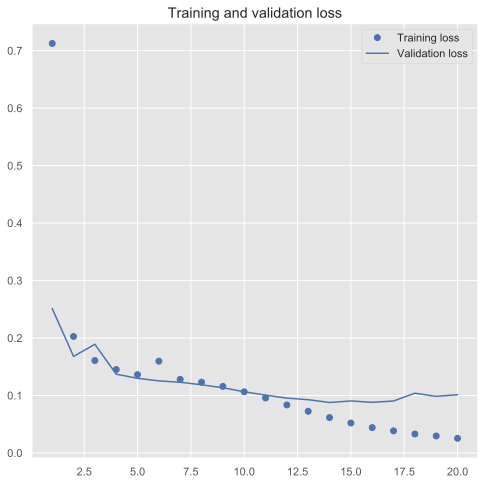

In [158]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [159]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [160]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [114]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true,labels=new_classes)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.66      0.44      0.53       203
       B-ORG       0.50      0.05      0.10        57
       B-PER       0.27      0.17      0.21       151
       I-LOC       0.18      0.15      0.16        27
       I-ORG       0.36      0.07      0.12        54
       I-PER       0.42      0.21      0.28       121

   micro avg       0.46      0.25      0.32       613
   macro avg       0.40      0.18      0.23       613
weighted avg       0.46      0.25      0.31       613



As we can see from the scores, Bi-LSTM model performs badly than hypertuned CRF scores.
Here we had only 2 articles for diving the train, validation and test dataset, that meant we had very few sentences for training and prediction

For deep learning algorithms like LSTM, performance grows according to a power law with the increase in the amount of data. From the above graphs we can see that the frequency of words belonging to PER and ORG classes were the least and hence they have the lowest scores as well and alternatively B-LOC has high word frequency, so better training and accuracy. So feeding more articles and sentences into the deep neural network models will lead to a great trained classifier and hence better predictions and better precision, recall and F1 scores.

The model could be further improved by hypertuning the parameters such as epochs, batch size, learning rate, embedding length, activation function, dropout etc.